In [1]:
import sys
sys.path.append("../..")
from community_accessibility import *

set_plot_formatting()

In [2]:
output_filename = 'output/median_ground_motion_comparison_results.h5'

with h5py.File(output_filename, 'r') as hf:

    cases = ast.literal_eval(hf['Results'].attrs.__getitem__('contents'))

In [3]:
case = 'baseline'
i_rup = 0

In [33]:
case_names = list(cases.keys())

# set values for calculating metrics
loss_col = 'Mean Community Days Lost'
time_frame = 12 * 30
time_frame_col = 'Mean community days lost\nwithin the first year'
community_threshold = 0.80
community_threshold_col = 'Days until mean recovery\nis at ' + '{:.0f}'.format(100*community_threshold) + '% functionality'

target_time = np.array([4, 12])
target_threshold = np.array([0.5, 0.5])

summary_results = pd.DataFrame(index=case_names)
summary_results[loss_col] = ''
summary_results[time_frame_col] = ''
summary_results[community_threshold_col] = ''

policy_col = list()
for p in range(len(target_time)):
    policy_col.append('% Likelihood of achieving\n' + '{:.0f}'.format(100*target_threshold[p]) + '% functionality in ' + '{:.0f}'.format(target_time[p]) + ' months')
    summary_results[policy_col[p]] = ''
    
deag_col = list()
deag_type = ['functional_repair', 'impeding_factor_delay', 'cordon_induced_delay']
for d in range(len(deag_type)):
    deag_col.append(deag_type[d] + ' losses in the first year')
    summary_results[deag_col[d]] = ''


i_occ = 1

for case in case_names:
    
    i_damage = cases[case]['i_damage']
    i_impeding_factors = cases[case]['i_impeding_factors']
    i_cordons = cases[case]['i_cordons']
    description = cases[case]['description']

    with h5py.File(output_filename, 'r') as hf:
        dset =   'Results' + \
                 '/CommunityDamage_' + str(i_damage) + \
                 '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
                 '/CordonLogistics/Cordons_' + str(i_cordons) + \
                 '/community_recovery'

        community_recovery = hf[dset][:]
        time = hf[dset].attrs.__getitem__('time')
        recovery_labels = hf[dset].attrs.__getitem__('recovery_labels')
        occupancy_labels = hf[dset].attrs.__getitem__('occupancy_labels')
        sqft_totals = hf[dset].attrs.__getitem__('sqft_totals')
        downtime_idx = np.where(recovery_labels=='total_downtime')[0]

    [_,_,_,_,n_sims] = community_recovery.shape
    for p in range(len(target_time)):
        time_idx = np.where(time == 30*target_time[p])[0]
        recovery_slice = np.squeeze(community_recovery[time_idx,i_rup,i_occ,downtime_idx,:])
        threshold_idx = np.searchsorted(np.sort(recovery_slice), target_threshold[p])
        summary_results.loc[case, policy_col[p]] = np.rint(100 * (1 - threshold_idx/n_sims))

    mean_community_recovery = np.mean(community_recovery, axis=4)

    days_to_community_threshold = np.interp(community_threshold, np.squeeze(mean_community_recovery[:, i_rup, i_occ, downtime_idx]), time)
    summary_results.loc[case, community_threshold_col] = np.rint(days_to_community_threshold)

    baseline_time = np.trapz(np.ones(len(time)), time)
    downtime = np.squeeze(mean_community_recovery[:, i_rup, i_occ, downtime_idx])
    downtime = (baseline_time - np.trapz(downtime, time))       
    summary_results.loc[case, loss_col] = np.rint(downtime)

    if time_frame is not None:
        n_time = np.where(time == time_frame)[0][0]+1
        time = time[:n_time]
        mean_community_recovery = mean_community_recovery[:n_time,:,:,:]

    baseline_time = np.trapz(np.ones(len(time)), time)
    downtime = np.squeeze(mean_community_recovery[:, i_rup, i_occ, downtime_idx])
    downtime = (baseline_time - np.trapz(downtime, time))       
    summary_results.loc[case, time_frame_col] = np.rint(downtime)
    
    lower_limit = 0
    idx_names = ['functional_repair', 'functional_downtime', 'total_downtime']
    for d in range(len(deag_type)):
        rec_idx = np.where(recovery_labels==idx_names[d])[0]
        loss = np.squeeze(mean_community_recovery[:, i_rup, i_occ, rec_idx])
        loss = (baseline_time - np.trapz(loss, time)) - lower_limit
        lower_limit = lower_limit + loss
        summary_results.loc[case, deag_col[d]] = np.rint(loss)
    
summary_results

,Mean Community Days Lost,Mean community days lost\nwithin the first year,Days until mean recovery\nis at 80% functionality,% Likelihood of achieving\n50% functionality in 4 months,% Likelihood of achieving\n50% functionality in 12 months,functional_repair losses in the first year,impeding_factor_delay losses in the first year,cordon_induced_delay losses in the first year
baseline,419,256,652,0,16,62,70,125


In [34]:
case = 'baseline'
with h5py.File(output_filename, 'r') as hf:

    cases = ast.literal_eval(hf['Results'].attrs.__getitem__('contents'))
    i_damage = cases[case]['i_damage']
    i_impeding_factors = cases[case]['i_impeding_factors']
    i_cordons = cases[case]['i_cordons']
    description = cases[case]['description']

    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/Hazard_and_Vulnerability_Sampling/ground_motion_map_indices'
    gm_map_indices = hf[dset][:]
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/community_damage'
    community_damage = hf[dset][:]
    damage_parameters = hf[dset].attrs.__getitem__('damage_parameters')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/community_downtime'
    community_downtime = hf[dset][:]
    downtime_parameters = hf[dset].attrs.__getitem__('downtime_parameters')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/community_recovery'
    community_recovery = 100 * hf[dset][:]
    time = hf[dset].attrs.__getitem__('time')
    recovery_labels = hf[dset].attrs.__getitem__('recovery_labels')
    occupancy_labels = hf[dset].attrs.__getitem__('occupancy_labels')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/CordonNetwork' +\
             '/cordon_durations'
    cordon_durations = hf[dset][:]
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/CordonNetwork' +\
             '/cordon_duration_adjacency'
    cordon_duration_adjacency = hf[dset][:]
    
    key = '/Results/'+\
          '/CommunityDamage_' + str(i_damage) + \
          '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
          '/CordonLogistics/Cordons_' + str(i_cordons) + \
          '/CordonNetwork/' + 'cordon_locations'
    cordon_locations = pd.read_hdf(output_filename, key=key)
    dset = hf[key]
    cordon_map = eval(dset.attrs.__getitem__('cordon_map'))
    cordon_map = gpd.GeoDataFrame.from_features(cordon_map)
    cordon_map.set_index('id', drop=True, inplace=True)
    cordon_map.crs = {'init': 'epsg:4326'}

C:\Users\ahul697\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
import matplotlib.transforms as mtrans
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch

def curly(x,y, scale, ax=None):
    if not ax: ax=plt.gca()
    tp = TextPath((0, 0), "}", size=1)
    trans = mtrans.Affine2D().scale(2.5*scale, scale) + \
        mtrans.Affine2D().translate(x,y) + ax.transData
    pp = PathPatch(tp, lw=0, fc="k", transform=trans, zorder=10)
    ax.add_artist(pp)

Number of sims plotted: 28


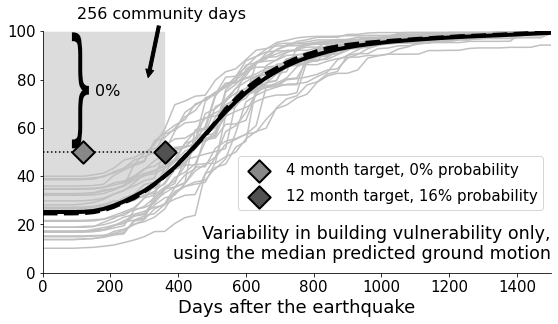

In [37]:
target_time = [30 * 4, 30 * 12]
target_threshold = [50] * len(target_time)

community_functionality_metric = 80
community_time_metric = 360

rec_idx = np.where(recovery_labels == 'total_downtime')[0]
occ_idx = np.where(occupancy_labels == 'Commercial Office')[0]
rup_idx = i_rup

community_recovery = community_recovery
[_,_,_,_,n_sims] = community_recovery.shape
sims_idx = range(1, n_sims, 36)
print('Number of sims plotted: ' + str(len(sims_idx)))

alpha = 1
[fig,ax] = plt.subplots(1,1,figsize=(8,4.5))
_ = plt.plot(time,community_recovery[:,rup_idx,occ_idx,rec_idx,sims_idx], color='silver', zorder=2, alpha=alpha)
community_mean = np.squeeze(np.mean(community_recovery[:,rup_idx,occ_idx,rec_idx,:],axis=2))
community_median = np.squeeze(np.median(community_recovery[:,rup_idx,occ_idx,rec_idx,:],axis=2))

time_idx = int(np.where(time==community_time_metric)[0]) + 1
_ = plt.fill_between(time[:time_idx], 100, community_mean[:time_idx], color='gainsboro', alpha=1, linewidth=0)

_ = plt.plot(time,community_mean, color='k', linewidth=4, zorder=3)
_ = plt.plot(time,community_median, color='k', ls='--', linewidth=4, zorder=3)

# x = np.interp(community_functionality_metric, community_mean, time)
# _ = plt.scatter(x, community_functionality_metric, color='tab:blue', zorder=4, s=100, label='Time until functionality is '+str(community_functionality_metric)+'%')

color_values = [0.55, 0.75]
color_palettes = ['Greys']*2
target_colors = [mpl.cm.get_cmap(color_palettes[i])(color_values[i])[:-1] for i in range(len(color_values))] 

for p in range(len(target_time)):
    time_idx = np.where(time == target_time[p])[0]
    recovery_slice = np.squeeze(community_recovery[time_idx,rup_idx,occ_idx,rec_idx,:])
    threshold_idx = np.searchsorted(np.sort(recovery_slice), target_threshold[p])
    q = 100 * (1-threshold_idx/n_sims)

    label = '{0:.0f}'.format(target_time[p]/30) + ' month target, ' + '{0:.0f}'.format(q) + '% probability'
    _ = plt.scatter(target_time[p], target_threshold[p], marker='D', s=250, color=target_colors[p], edgecolor='k', linewidth=2, label=label, zorder=10)
_ = plt.plot([0,target_time[-1]],[50]*2,':k')
_ = ax.legend(handlelength=2, labelspacing=0.75,bbox_to_anchor=(1,0.23),loc='lower right')

_ = plt.xlim([0,1500])
_ = plt.ylim([0,100])
_ = ax.spines['right'].set_visible(False)
_ = ax.spines['top'].set_visible(False)

ylabel = 'Accessible '+occupancy_labels[occ_idx][0]+',\n% of pre-event space'
ylabel = 'Accessible Office Space\n[% of pre-event space]'
_ = plt.ylabel('')
_ = plt.xlabel('Days after the earthquake')
_ = plt.tight_layout()

_ = ax.annotate('Variability in building vulnerability only,\nusing the median predicted ground motion', [1500, 12],
               ha='right', va='center', fontsize=17.5)

fontsize = 16
curly(70,60,52, ax=None)
text = '{0:.0f}%'.format(summary_results.loc['baseline','% Likelihood of achieving\n50% functionality in 4 months'])
_ = plt.annotate(text,fontsize=fontsize,
            xy=(155, 75), ha='left', va='center'
            )

n_days = summary_results.loc['baseline','Mean community days lost\nwithin the first year']
text = '{0:.0f} community days'.format(n_days)
arrow_start=(310,80)
arrow_end  =(350,110)
_ = plt.annotate(text, fontsize=fontsize, ha='center', va='top',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle='simple',
                                color='k',
                                connectionstyle='arc3'))


filename = 'summary_statistics_given_median_ground_motion'
plt.savefig('figures_pdf/'+filename+'.pdf', bbox_inches='tight', pad_inches=0.1)
plt.savefig('figures_png/'+filename+'.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

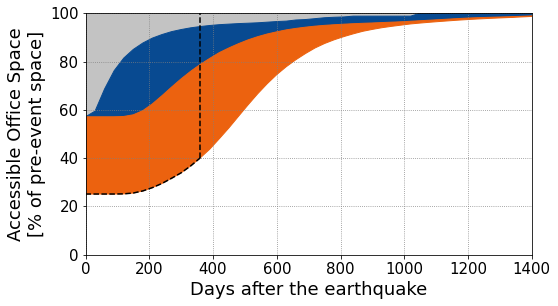

In [7]:
occ_labels = ['Residential', 'Office', 'All Occupancies']
i_occ = 1
xlim = [0, 1400]
case = 'baseline'
legend = False

[fig,ax] = plt.subplots(1,1,figsize=(8,4.5))

for i_rup in [i_rup]:

    i_damage = cases[case]['i_damage']
    i_impeding_factors = cases[case]['i_impeding_factors']
    i_cordons = cases[case]['i_cordons']
    description = cases[case]['description']

    with h5py.File(output_filename, 'r') as hf:
        dset =   'Results' + \
                 '/CommunityDamage_' + str(i_damage) + \
                 '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
                 '/CordonLogistics/Cordons_' + str(i_cordons) + \
                 '/community_recovery'

        community_recovery = hf[dset][:]
        time = hf[dset].attrs.__getitem__('time')
        recovery_labels = hf[dset].attrs.__getitem__('recovery_labels')
        sqft_totals = hf[dset].attrs.__getitem__('sqft_totals')
        downtime_idx = np.where(recovery_labels=='total_downtime')[0]
        
grid_plot_mean_community_recovery(community_recovery, time, xlim, i_rup, i_occ, sqft_totals, ax, legend)
_ = ax.set_xlim(xlim)
_ = ax.set_ylim([0,100])

ylabel = 'Accessible Office Space\n[% of pre-event space]'
_ = plt.ylabel(ylabel)
_ = plt.xlabel('Days after the earthquake')
_ = plt.tight_layout()